In [1]:
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import pandas as pd

## Dams shapefile

In [2]:
reservoirsShapefilePath = '/home/lamductan/Hydroviet/github/DataNotebook/reservoirsShapefile/'
hydrobasinPath = reservoirsShapefilePath + 'hydrobasinl6se-asia'
hydropowerReservoirsPath = reservoirsShapefilePath + 'hydropowerreservoirs'
mekongDamsPath = reservoirsShapefilePath + 'mekongdamsgms'

In [3]:
hydrobasin = gpd.read_file(hydrobasinPath)
hydropowerReservoirs = gpd.read_file(hydropowerReservoirsPath)
mekongDams = gpd.read_file(mekongDamsPath)

hydrobasin = hydrobasin.to_crs({'init': 'epsg:4326'})
hydropowerReservoirs = hydropowerReservoirs.to_crs({'init': 'epsg:4326'})
mekongDams = mekongDams.to_crs({'init': 'epsg:4326'})

## Reservoirs shapefile

In [4]:
aoi2Path = reservoirsShapefilePath + 'aoi2reservoirs'
aoi2Reservoirs = gpd.read_file(aoi2Path)

reservoirsShapefile = {}
reservoirsShapefile['VNM'] = aoi2Reservoirs[aoi2Reservoirs['COUNTRY'] =='Vietnam']
reservoirsShapefile['LAO'] = aoi2Reservoirs[aoi2Reservoirs['COUNTRY'] =='Laos']
reservoirsShapefile['THA'] = aoi2Reservoirs[aoi2Reservoirs['COUNTRY'] =='Thailand']

In [5]:
mekongReservoirsAndDams = aoi2Reservoirs.copy()
mekongReservoirsAndDams = mekongReservoirsAndDams.append(mekongDams)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


## Rivers shapefile

In [6]:
riversShapefilePath = '/home/lamductan/Hydroviet/github/DataNotebook/reservoirsShapefile/'
laRiversPath = riversShapefilePath + 'laorivers'
vnRiversPath = riversShapefilePath + 'vnrivers'
tlRiversPath = riversShapefilePath + 'tlrivers'
cbRiversPath = riversShapefilePath + 'cbrivers'

In [7]:
riversShapefile = {}
riversShapefile['VNM'] = gpd.read_file(vnRiversPath)
riversShapefile['LAO'] = gpd.read_file(laRiversPath)
riversShapefile['THA'] = gpd.read_file(tlRiversPath)
riversShapefile['KHM'] = gpd.read_file(cbRiversPath)

In [8]:
'''
rivers = riversShapefile['VNM'].copy()
rivers = rivers.append(riversShapefile['LAO'])
rivers = rivers.append(riversShapefile['THA'])
rivers = rivers.append(riversShapefile['KHM'])
'''
rivers = gpd.read_file(reservoirsShapefilePath + 'gmsriversadb')

## Countries shapefile

In [9]:
countryShapefilePath = '/home/lamductan/Hydroviet/github/DataNotebook/CountryShapefile/'
vnShapefilePath = countryShapefilePath + 'vnShapefile/VNM_adm1.shp'
laShapefilePath = countryShapefilePath + 'laShapefile/LAO_adm1.shp'
cbShapefilePath = countryShapefilePath + 'cbShapefile/KHM_adm1.shp'
tlShapefilePath = countryShapefilePath + 'tlShapefile/THA_adm1.shp'

In [10]:
countryShapefile = {}
countryShapefile['VNM'] = gpd.read_file(vnShapefilePath)
countryShapefile['LAO'] = gpd.read_file(laShapefilePath)
countryShapefile['KHM'] = gpd.read_file(cbShapefilePath)
countryShapefile['THA'] = gpd.read_file(tlShapefilePath)

In [11]:
mekongCountriesShapefile = countryShapefile['VNM'].copy()
mekongCountriesShapefile = mekongCountriesShapefile.append(countryShapefile['LAO'])
mekongCountriesShapefile = mekongCountriesShapefile.append(countryShapefile['KHM'])
mekongCountriesShapefile = mekongCountriesShapefile.append(countryShapefile['THA'])

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


## Overlay countries, rivers, reservoirs and dams

In [12]:
def overlayRiversReservoirsDams(countryShapefile, 
                                riversShapefile=None, 
                                reservoirsShapefile=None, 
                                damsShapefile=None, 
                                ax=None, 
                                figsize=20, 
                                reservoirScale=1.0):
    
    from matplotlib.collections import PatchCollection
    from shapely.geometry import Polygon, MultiPolygon, shape, box, Point
    from shapely.affinity import scale
    from descartes import PolygonPatch
    from matplotlib import pyplot as plt

    if ax is None:
        fig = plt.figure(figsize = (figsize,figsize))
        ax = fig.add_subplot(111)

    shapes = [shape(p) for p in countryShapefile['geometry']]
    mp = MultiPolygon(shapes)
    xmin, ymin, xmax, ymax = mp.bounds
    w, h = xmax - xmin, ymax - ymin

    ax.set_xlim(xmin - 0.2 * w, xmax + 0.2 * w)
    ax.set_ylim(ymin - 0.2 * h, ymax + 0.2 * h)
    ax.set_aspect(1.0)

    patches = []
    for provinceShape in shapes:
        patches.append(PolygonPatch(provinceShape, fc='none', ec='#555555', zorder=0))
    
    if riversShapefile is not None:
        for riverShapefile in riversShapefile['geometry']:
            bounds = riverShapefile.bounds
            rectBox = box(*bounds)
            p = riverShapefile.buffer(0.001)
            patches.append(PolygonPatch(p, fc='aqua', ec='aqua', zorder=1))
    
    if reservoirsShapefile is not None:
        for reservoirShapefile in reservoirsShapefile['geometry']:
            p = shape(reservoirShapefile)
            p = scale(p, xfact=reservoirScale, yfact=reservoirScale)
            patches.append(PolygonPatch(p, fc='blue', ec='#555555', zorder=1))
    
    if damsShapefile is not None:
        for damShapefile in damsShapefile['geometry']:
            p = shape(damShapefile)
            p = p.buffer(0.05)
            patches.append(PolygonPatch(p, fc='blue', ec='#555555', zorder=1))
    
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)
    ax.axis('off')
    
    plt.show()
    return ax


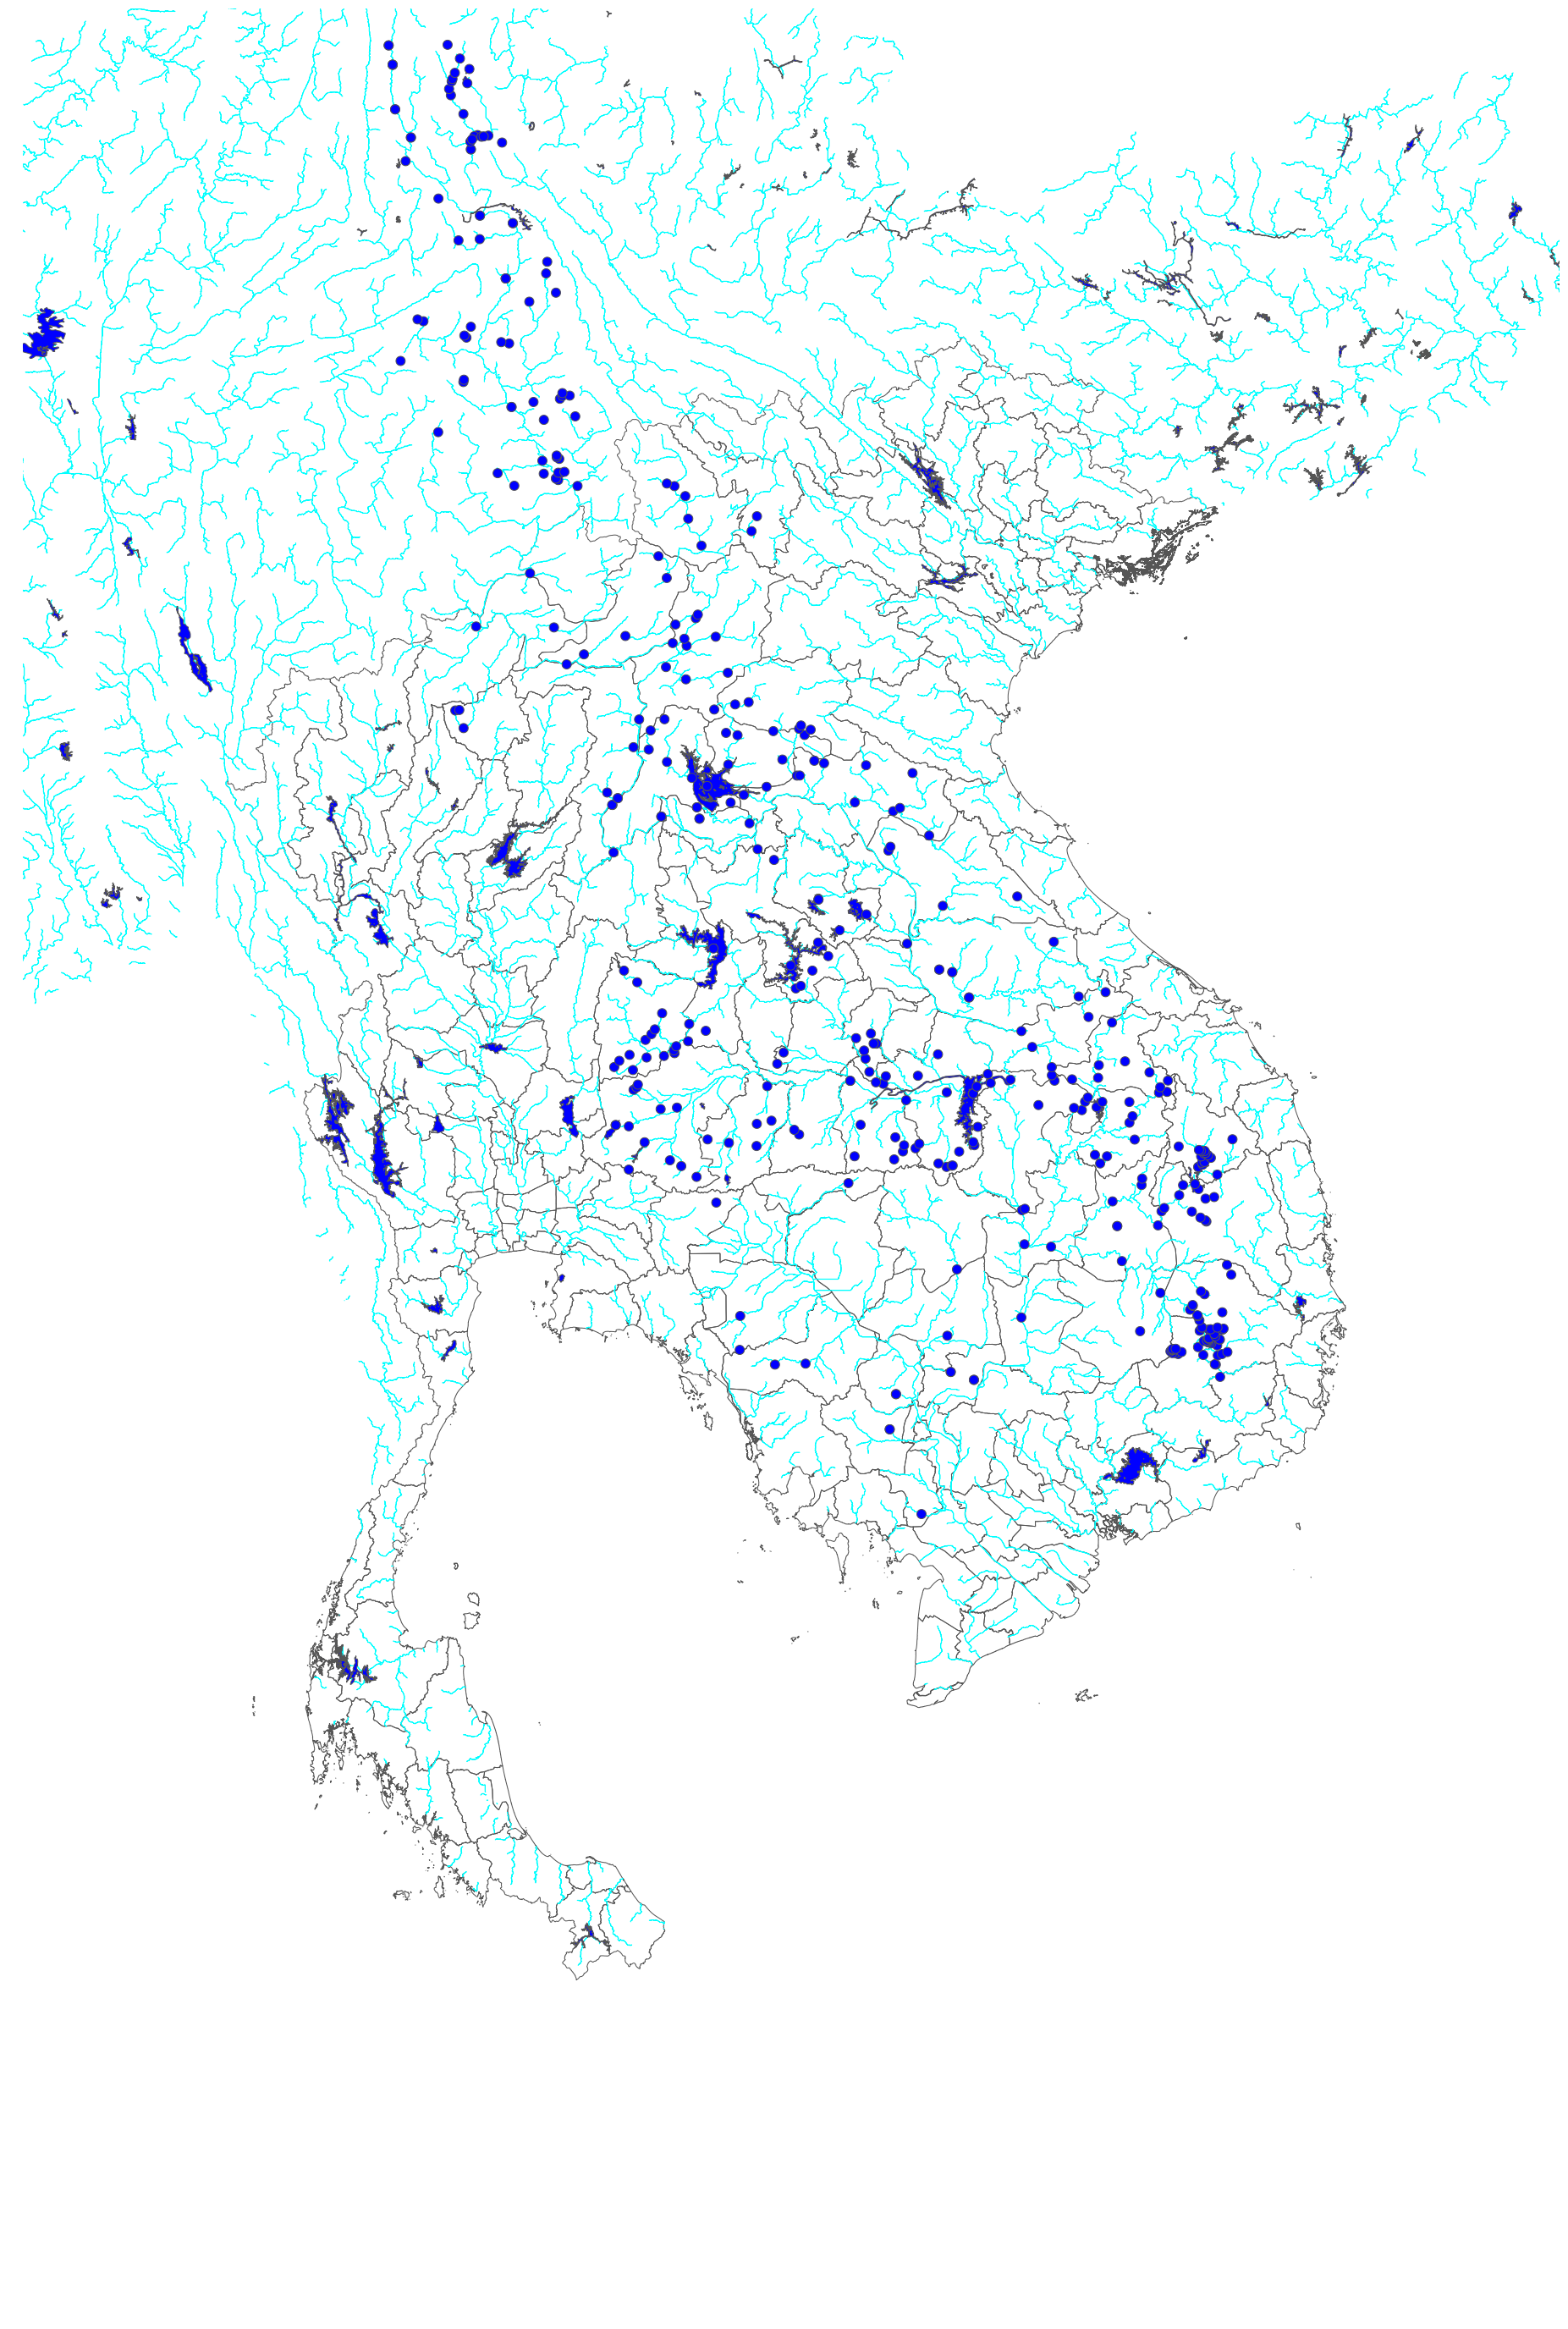

In [13]:
overlayRiversReservoirsDams(countryShapefile=mekongCountriesShapefile,
                           riversShapefile=rivers,
                           reservoirsShapefile=aoi2Reservoirs,
                           damsShapefile=mekongDams,
                           figsize=50,
                           reservoirScale=2.0)

## Find reservoirs and dams lay on each river in gmsriversadb shapefile.

In [14]:
import os

reservoirsAndDamsPerRiver = []

if not os.path.isfile('reservoirsAndDamsPerRiver.txt'):
    import time
    start = time.time()

    with open('reservoirsAndDamsPerRiver.txt', 'w') as f:
        for i in range(rivers.shape[0]):
            f.write(str(i))
            t = time.time()
            currentRiver = rivers.iloc[i]['geometry']
            reservoirsAndDamsCurrentRiver = []
            for j in range(mekongReservoirsAndDams.shape[0]):
                currentWater = mekongReservoirsAndDams.iloc[j]['geometry']
                if currentRiver.intersects(currentWater):
                    reservoirsAndDamsCurrentRiver.append(j)
                    f.write(',' + str(j))
            reservoirsAndDamsPerRiver.append(reservoirsAndDamsCurrentRiver)
            if i % 100 == 0:
                timeElapsed = time.time() - t
                print(i, end = '     ')
                print('Time elapsed %d' % timeElapsed)
            f.write('\n')

        timeElapsed = time.time() - start
        print('Time elapsed %d' % timeElapsed)
    
    f.close()

else:
    with open('reservoirsAndDamsPerRiver.txt', 'r') as f:
        for line in f.readlines():
            line = line.strip('\n\r')
            data = line.split(',')
            if len(data) == 1:
                reservoirsAndDamsPerRiver.append([])
            else:
                reservoirsAndDamsCurrentRiver = [int(data[i]) for i in range(1, len(data))]
                reservoirsAndDamsPerRiver.append(reservoirsAndDamsCurrentRiver)
    f.close()

### Print rivers' name and list of reservoirs and dams on them

In [15]:
for i in range(len(reservoirsAndDamsPerRiver)):
    if (len(reservoirsAndDamsPerRiver[i])) > 0:
        print('{} - {}: '.format(i, rivers.iloc[i]['Sub_Name']), end = '')
        print(reservoirsAndDamsPerRiver[i])
        for index in reservoirsAndDamsPerRiver[i]:
            print('{}, '.format(mekongReservoirsAndDams.iloc[index]['local_name']), end = '')
        print()

30 - Zou Jiang4: [53]
nan, 
43 - Zou Jiang1: [50]
nan, 
50 - Yu Jiang1: [47]
nan, 
51 - Yu Jiang1: [47]
nan, 
53 - Yu Jiang1: [47]
nan, 
54 - Yu Jiang1: [48]
nan, 
85 - Wuli Jiang /  Nanliu Jiang: [54]
nan, 
91 - Wuli Jiang /  Nanliu Jiang: [56]
nan, 
157 - Song Bo1: [108]
nan, 
166 - Chay: [107]
nan, 
167 - Chay: [107]
nan, 
604 - Lake Inle: [69]
nan, 
605 - Lake Inle: [69]
nan, 
606 - Lake Inle: [69]
nan, 
702 - Zawgyi: [64]
nan, 
796 - Yin: [66]
nan, 
797 - Yin: [66]
nan, 
798 - Yin: [66]
nan, 
810 - Irrawaddy3: [68]
nan, 
966 - Nam Ngum: [57]
nan, 
967 - Nam Ngum: [57]
nan, 
968 - Nam Ngum: [57]
nan, 
969 - Nam Ngum: [57]
nan, 
971 - Nam Ngum: [57]
nan, 
1037 - Songkhram: [80]
nan, 
1096 - Nam Kam / Nam Hinboun / Huai: [82]
nan, 
1100 - Nam Kam / Nam Hinboun / Huai: [82]
nan, 
1102 - Nam Kam / Nam Hinboun / Huai: [82]
nan, 
1123 - Nam Chi: [84]
nan, 
1124 - Nam Chi: [84]
nan, 
1125 - Nam Chi: [85]
nan, 
1126 - Nam Chi: [85]
nan, 
1128 - Nam Chi: [84]
nan, 
1129 - Nam Chi: [84]
nan,

## Plot some specific rivers you want. List them in listRiverName

In [16]:
def overlayRiversReservoirsDams_2(countryShapefile, 
                                riversShapefile=None, 
                                reservoirsShapefile=None, 
                                damsShapefile=None, 
                                ax=None, 
                                figsize=20, 
                                reservoirScale=1.0,
                                listRiverName=None):
    
    from matplotlib.collections import PatchCollection
    from shapely.geometry import Polygon, MultiPolygon, shape, box, Point
    from shapely.affinity import scale
    from descartes import PolygonPatch
    from matplotlib import pyplot as plt

    if ax is None:
        fig = plt.figure(figsize = (figsize,figsize))
        ax = fig.add_subplot(111)

    shapes = [shape(p) for p in countryShapefile['geometry']]
    mp = MultiPolygon(shapes)
    xmin, ymin, xmax, ymax = mp.bounds
    w, h = xmax - xmin, ymax - ymin

    ax.set_xlim(xmin - 0.2 * w, xmax + 0.2 * w)
    ax.set_ylim(ymin - 0.2 * h, ymax + 0.2 * h)
    ax.set_aspect(1.0)

    patches = []
    for provinceShape in shapes:
        patches.append(PolygonPatch(provinceShape, fc='none', ec='#555555', zorder=0))
    
    if riversShapefile is not None:
        for i in range(riversShapefile.shape[0]):
            riverShapefile = riversShapefile.iloc[i]
            if listRiverName is not None:
                if riverShapefile['Sub_Name'] in listRiverName:
                    riverShapefile = riverShapefile['geometry']
                    bounds = riverShapefile.bounds
                    rectBox = box(*bounds)
                    p = riverShapefile.buffer(0.001)
                    patches.append(PolygonPatch(p, fc='aqua', ec='aqua', zorder=1))
    
    if reservoirsShapefile is not None:
        for reservoirShapefile in reservoirsShapefile['geometry']:
            p = shape(reservoirShapefile)
            p = scale(p, xfact=reservoirScale, yfact=reservoirScale)
            patches.append(PolygonPatch(p, fc='blue', ec='#555555', zorder=1))
    
    if damsShapefile is not None:
        for damShapefile in damsShapefile['geometry']:
            p = shape(damShapefile)
            p = p.buffer(0.05)
            patches.append(PolygonPatch(p, fc='blue', ec='#555555', zorder=1))
    
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)
    ax.axis('off')
    
    plt.show()
    return ax


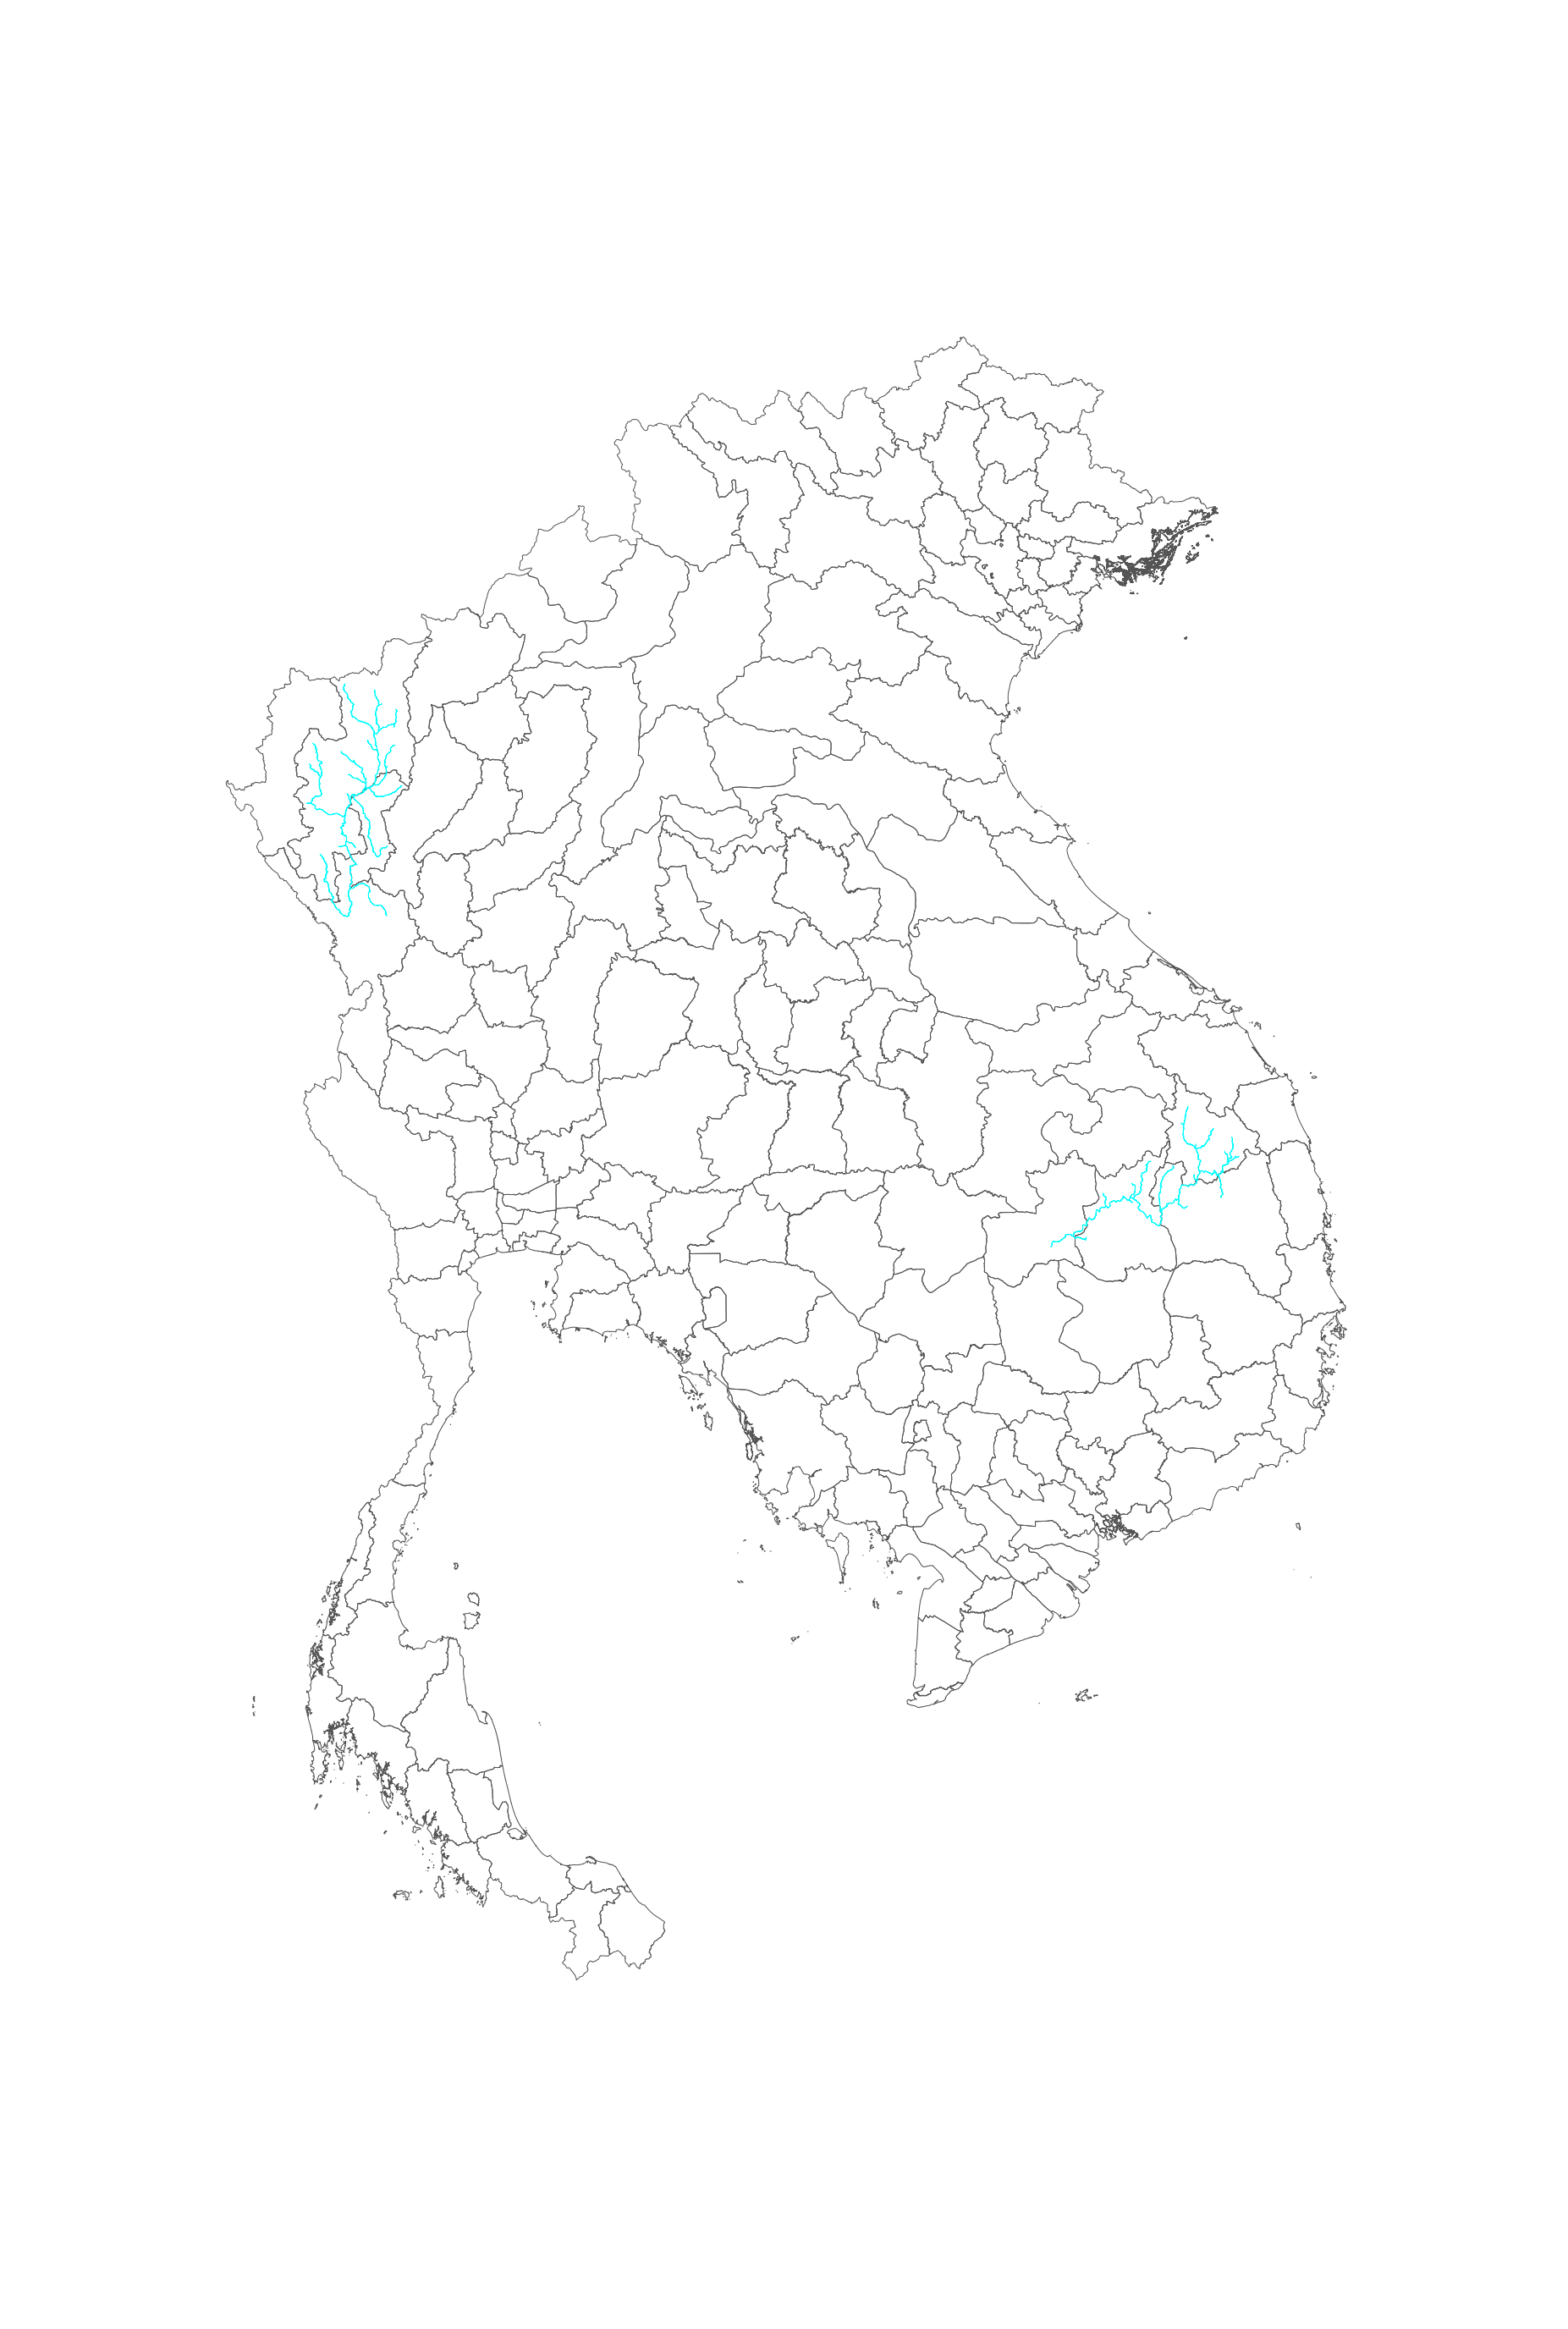

In [17]:
overlayRiversReservoirsDams_2(countryShapefile=mekongCountriesShapefile,
                           riversShapefile=rivers,
                           figsize=50,
                           reservoirScale=2.0,
                           listRiverName=['Se San', 'Mae Nam Wang'])

### Many of rivers do not have any reservoirs. Very few reservoirs and dams lay on the same river.

In [18]:
print(reservoirsAndDamsPerRiver)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [53], [], [], [], [], [], [], [], [], [], [], [], [], [50], [], [], [], [], [], [], [47], [47], [], [47], [48], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [54], [], [], [], [], [], [56], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [108], [], [], [], [], [], [], [], [], [107], [107], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []

In [19]:
def overlayRiversReservoirsDams_3(countryShapefile, 
                                riversShapefile=None, 
                                reservoirsShapefile=None, 
                                ax=None, 
                                figsize=20, 
                                reservoirScale=1.0,
                                listRiverName=None,
                                reservoirsAndDamsPerRiver=None):
    
    from matplotlib.collections import PatchCollection
    from shapely.geometry import Polygon, MultiPolygon, shape, box, Point
    from shapely.affinity import scale
    from descartes import PolygonPatch
    from matplotlib import pyplot as plt

    if ax is None:
        fig = plt.figure(figsize = (figsize,figsize))
        ax = fig.add_subplot(111)

    shapes = [shape(p) for p in countryShapefile['geometry']]
    mp = MultiPolygon(shapes)
    xmin, ymin, xmax, ymax = mp.bounds
    w, h = xmax - xmin, ymax - ymin

    ax.set_xlim(xmin - 0.2 * w, xmax + 0.2 * w)
    ax.set_ylim(ymin - 0.2 * h, ymax + 0.2 * h)
    ax.set_aspect(1.0)

    patches = []
    for provinceShape in shapes:
        patches.append(PolygonPatch(provinceShape, fc='none', ec='#555555', zorder=0))
    
    if riversShapefile is not None:
        for i in range(riversShapefile.shape[0]):
            riverShapefile = riversShapefile.iloc[i]
            if listRiverName is not None:
                if riverShapefile['Sub_Name'] not in listRiverName:
                    continue
            riverShapefile = riverShapefile['geometry']
            bounds = riverShapefile.bounds
            rectBox = box(*bounds)
            p = riverShapefile.buffer(0.001)
            patches.append(PolygonPatch(p, fc='aqua', ec='aqua', zorder=1))
    
    if reservoirsShapefile is not None:
        for reservoirShapefile in reservoirsShapefile['geometry']:
            p = shape(reservoirShapefile)
            p = scale(p, xfact=reservoirScale, yfact=reservoirScale)
            patches.append(PolygonPatch(p, fc='blue', ec='#555555', zorder=1))
            
    reservoirColor = ['r', 'g', 'c', 'm', 'y', 'k']
    cnt = 0
    mod = len(reservoirColor)
    for reservoirsAndDamsCurrentRiver in reservoirsAndDamsPerRiver:
        if len(reservoirsAndDamsCurrentRiver) >= 2:
            color = reservoirColor[cnt % mod]
            cnt += 1
            for i in reservoirsAndDamsCurrentRiver:
                reservoirShapefile = reservoirsShapefile.iloc[i]['geometry']
                p = shape(reservoirShapefile)
                p = scale(p, xfact=reservoirScale, yfact=reservoirScale)
                patches.append(PolygonPatch(p, fc=color, ec='#555555', zorder=1))
            
    
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)
    ax.axis('off')
    
    plt.show()
    return ax


## Reservoirs and Dams which have the same color, except blue, lay on the same river. 

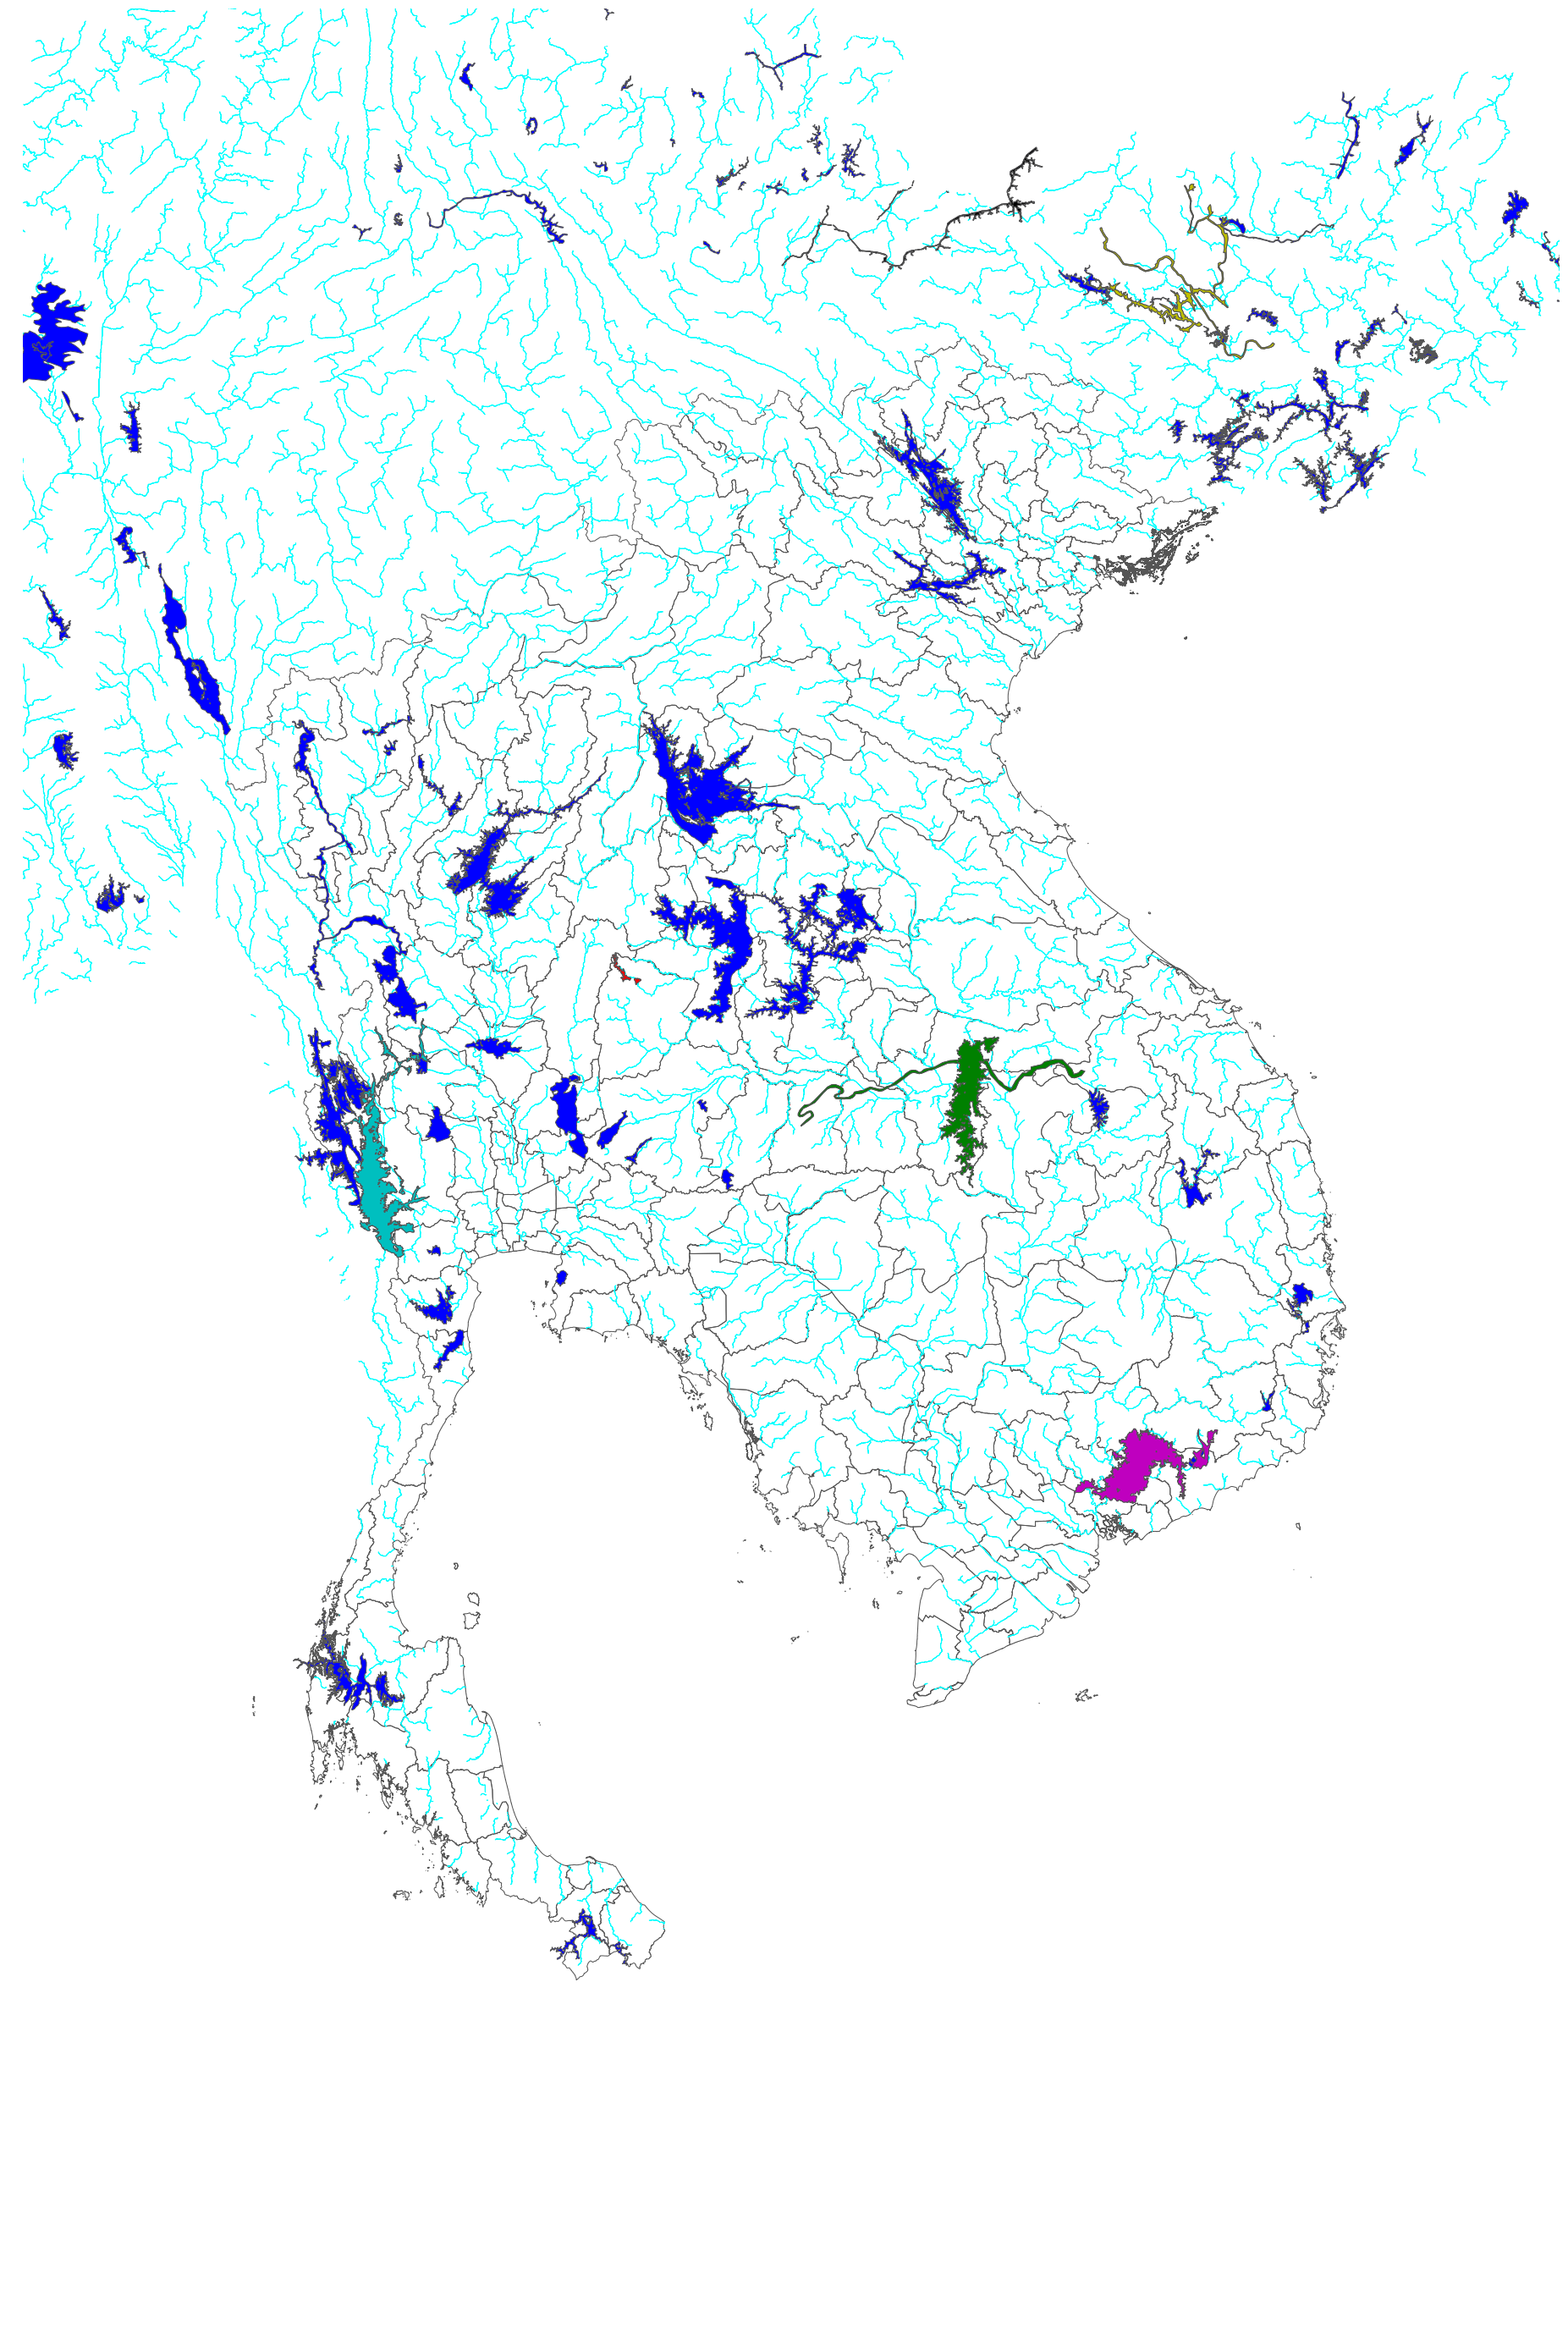

In [20]:
overlayRiversReservoirsDams_3(countryShapefile=mekongCountriesShapefile,
                           riversShapefile=rivers,
                           reservoirsShapefile=aoi2Reservoirs,
                           figsize=50,
                           reservoirScale=4.0,
                           reservoirsAndDamsPerRiver=reservoirsAndDamsPerRiver)

## Very few reservoirs and dams lay on the same river. Below is list of them. 

In [21]:
for i in range(len(reservoirsAndDamsPerRiver)):
    if (len(reservoirsAndDamsPerRiver[i])) >= 2:
        print('{} - {}: '.format(i, rivers.iloc[i]['Sub_Name']), end = '')
        print(reservoirsAndDamsPerRiver[i])
        for index in reservoirsAndDamsPerRiver[i]:
            print('{}, '.format(mekongReservoirsAndDams.iloc[index]['local_name']), end = '')
        print()

1159 - Nam Chi: [86, 87]
nan, nan, 
1309 - Nam Mun: [105, 106]
nan, nan, 
2404 - MaeKhlong: [96, 98]
nan, nan, 
2874 - Lagna Da Rgna: [112, 114]
nan, nan, 
3235 - Hongshiu He2: [32, 37]
nan, nan, 
4216 - Nanpan Jiang2: [19, 27]
nan, nan, 
